<a href="https://colab.research.google.com/github/Chandra953/Crime-Forecasting/blob/main/Crime-Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing all libraries

In [49]:
# Step 1: Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
import geopandas as gpd
import folium
from folium.plugins import HeatMap
from sklearn.cluster import DBSCAN

#Loading the Datasets

In [50]:
# Step 2: Load the Data
file1_path = '/content/NIJ2017_FEB01_FEB14.xlsx'
file2_path = '/content/NIJ2017_FEB15_FEB21.xlsx'

# Load the Excel files
data1 = pd.read_excel(file1_path)
data2 = pd.read_excel(file2_path)

# Combine the datasets
data = pd.concat([data1, data2], ignore_index=True)

# Preview the data
print(data.head())
print(data.info())

        CATEGORY CALL GROUPS final_case_type  \
0  STREET CRIMES    DISORDER          DISTP    
1  STREET CRIMES    DISORDER          DISTP    
2  STREET CRIMES    DISORDER          DISTP    
3  STREET CRIMES    DISORDER          DISTP    
4  STREET CRIMES    DISORDER          DISTP    

                                           CASE DESC   occ_date  x_coordinate  \
0  DISTURBANCE - PRIORITY                        ... 2017-02-01       7642139   
1  DISTURBANCE - PRIORITY                        ... 2017-02-01       7643527   
2  DISTURBANCE - PRIORITY                        ... 2017-02-01       7644834   
3  DISTURBANCE - PRIORITY                        ... 2017-02-01       7665551   
4  DISTURBANCE - PRIORITY                        ... 2017-02-01       7670677   

   y_coordinate  census_tract  
0        679235        5600.0  
1        683935       10600.0  
2        686438        5100.0  
3        692821        2901.0  
4        679049        1602.0  
<class 'pandas.core.frame.DataFr

#Check for missing values and Clean the data

In [51]:
#step 3
# Checking for missing values
print(data.isnull().sum())

# Fill or drop missing values as necessary
# Example: Dropping rows with missing values
data.dropna(inplace=True)

# Rename columns for consistency if necessary
data.columns = [col.lower().replace(" ", "_") for col in data.columns]

# Convert date and time columns to datetime objects
data['occ_date'] = pd.to_datetime(data['occ_date'])

# Extract useful features like hour, day, and month
data['day'] = data['occ_date'].dt.day
data['weekday'] = data['occ_date'].dt.weekday
data['month'] = data['occ_date'].dt.month

# Preview the cleaned data
print(data.head())



CATEGORY             0
CALL GROUPS          0
final_case_type      0
CASE DESC            0
occ_date             0
x_coordinate         0
y_coordinate         0
census_tract       548
dtype: int64
        category call_groups final_case_type  \
0  STREET CRIMES    DISORDER          DISTP    
1  STREET CRIMES    DISORDER          DISTP    
2  STREET CRIMES    DISORDER          DISTP    
3  STREET CRIMES    DISORDER          DISTP    
4  STREET CRIMES    DISORDER          DISTP    

                                           case_desc   occ_date  x_coordinate  \
0  DISTURBANCE - PRIORITY                        ... 2017-02-01       7642139   
1  DISTURBANCE - PRIORITY                        ... 2017-02-01       7643527   
2  DISTURBANCE - PRIORITY                        ... 2017-02-01       7644834   
3  DISTURBANCE - PRIORITY                        ... 2017-02-01       7665551   
4  DISTURBANCE - PRIORITY                        ... 2017-02-01       7670677   

   y_coordinate  census_tra

#Visualization of Crimes by category
#Crime rate by date

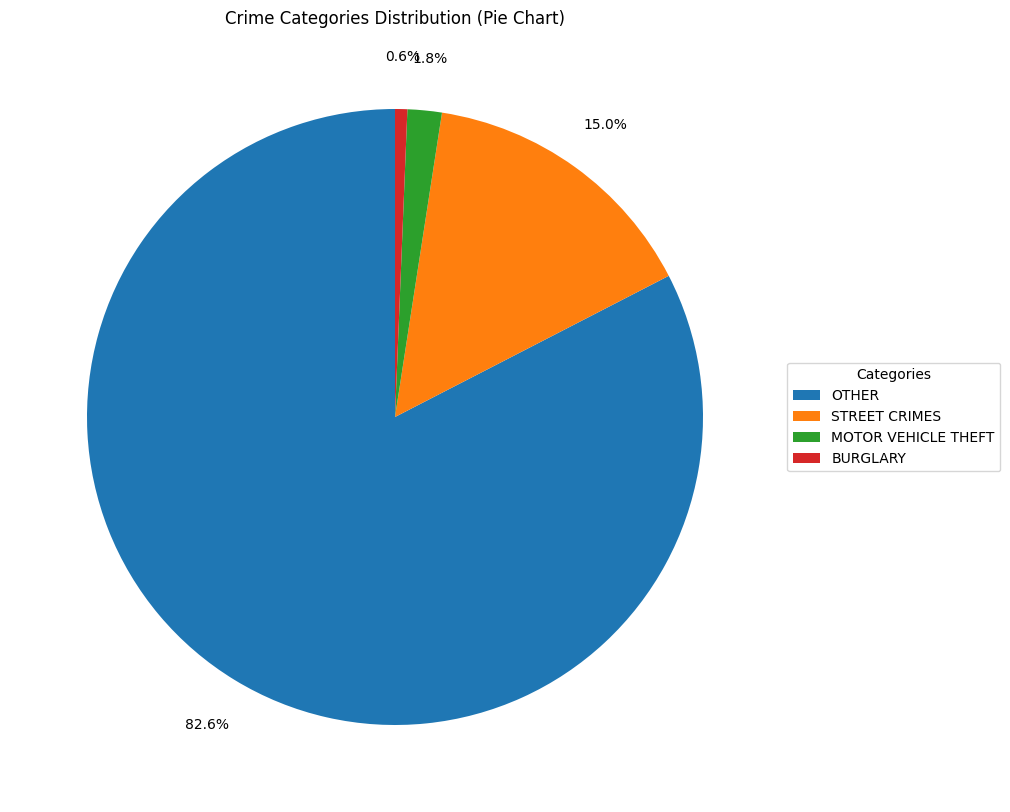

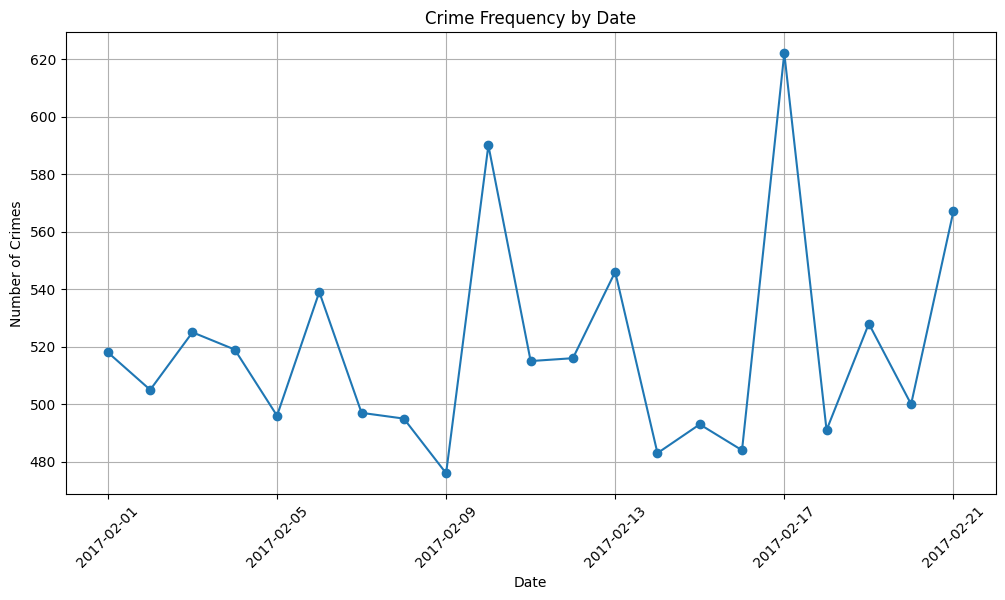

In [52]:
#Step 4
import matplotlib.pyplot as plt

# Function to display percentages outside the pie chart
def autopct_outside(pct, all_vals):
    total = sum(all_vals)
    val = int(round(pct * total / 100.0))
    return f'{pct:.1f}%'

# Plotting pie chart for the distribution of crimes by category
category_counts = data['category'].value_counts()
plt.figure(figsize=(10, 10))

wedges, texts, autotexts = plt.pie(
    category_counts,
    labels=None,  # Hide labels on the pie; they'll appear in the legend
    autopct=lambda pct: autopct_outside(pct, category_counts),
    startangle=90,
    pctdistance=0.9,
    textprops=dict(color="black")
)

# Adjust percentage text positions to be outside the pie
for autotext in autotexts:
    autotext.set_position([autotext.get_position()[0] * 1.3, autotext.get_position()[1] * 1.3])

# Add legend for category labels
plt.legend(wedges, category_counts.index, title="Categories", loc="center left", bbox_to_anchor=(1, 0.5))

plt.title("Crime Categories Distribution (Pie Chart)")
plt.show()




# Plot the distribution of crimes by date
plt.figure(figsize=(12, 6))
crime_counts_by_date = data['occ_date'].value_counts().sort_index()
plt.plot(crime_counts_by_date.index, crime_counts_by_date.values, marker='o')
plt.title("Crime Frequency by Date")
plt.xlabel("Date")
plt.ylabel("Number of Crimes")
plt.xticks(rotation=45)
plt.grid()
plt.show()




#DBSCAN clustering ML Algorithem
Points that belong to the same cluster (as identified by the DBSCAN algorithm) will have the same color.

Noise points (outliers) that do not belong to any cluster will typically be colored differently (e.g., black or gray).


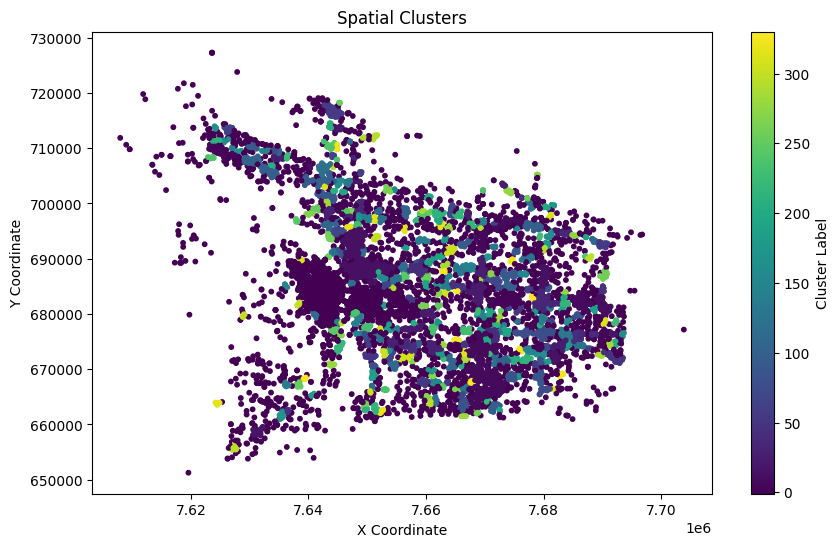

Processed data with clusters saved as 'processed_clusters.csv'


In [53]:
#Step 5
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Load and combine datasets
file1_path = '/content/NIJ2017_FEB01_FEB14.xlsx'
file2_path = '/content/NIJ2017_FEB15_FEB21.xlsx'
data1 = pd.ExcelFile(file1_path).parse(sheet_name=0)
data2 = pd.ExcelFile(file2_path).parse(sheet_name=0)
data = pd.concat([data1, data2], ignore_index=True)

# Rename columns to a consistent format
data.rename(columns=lambda x: x.strip().lower().replace(" ", "_"), inplace=True)

# Extract coordinates and drop missing values
coordinates = data[['x_coordinate', 'y_coordinate']]
coordinates_clean = coordinates.dropna()

# Perform DBSCAN clustering ML Algorithem
db = DBSCAN(eps=500, min_samples=5).fit(coordinates_clean)
data['hotspot_cluster'] = -1  # Default for rows with NaN coordinates
data.loc[coordinates_clean.index, 'hotspot_cluster'] = db.labels_

# Visualize clusters
plt.figure(figsize=(10, 6))
plt.scatter(coordinates_clean['x_coordinate'], coordinates_clean['y_coordinate'],
            c=db.labels_, cmap='viridis', s=10)
plt.title("Spatial Clusters")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.colorbar(label="Cluster Label")
plt.show()

# Save processed data with cluster labels
data.to_csv('processed_clusters.csv', index=False)
print("Processed data with clusters saved as 'processed_clusters.csv'")


#Heigh risk areas predection

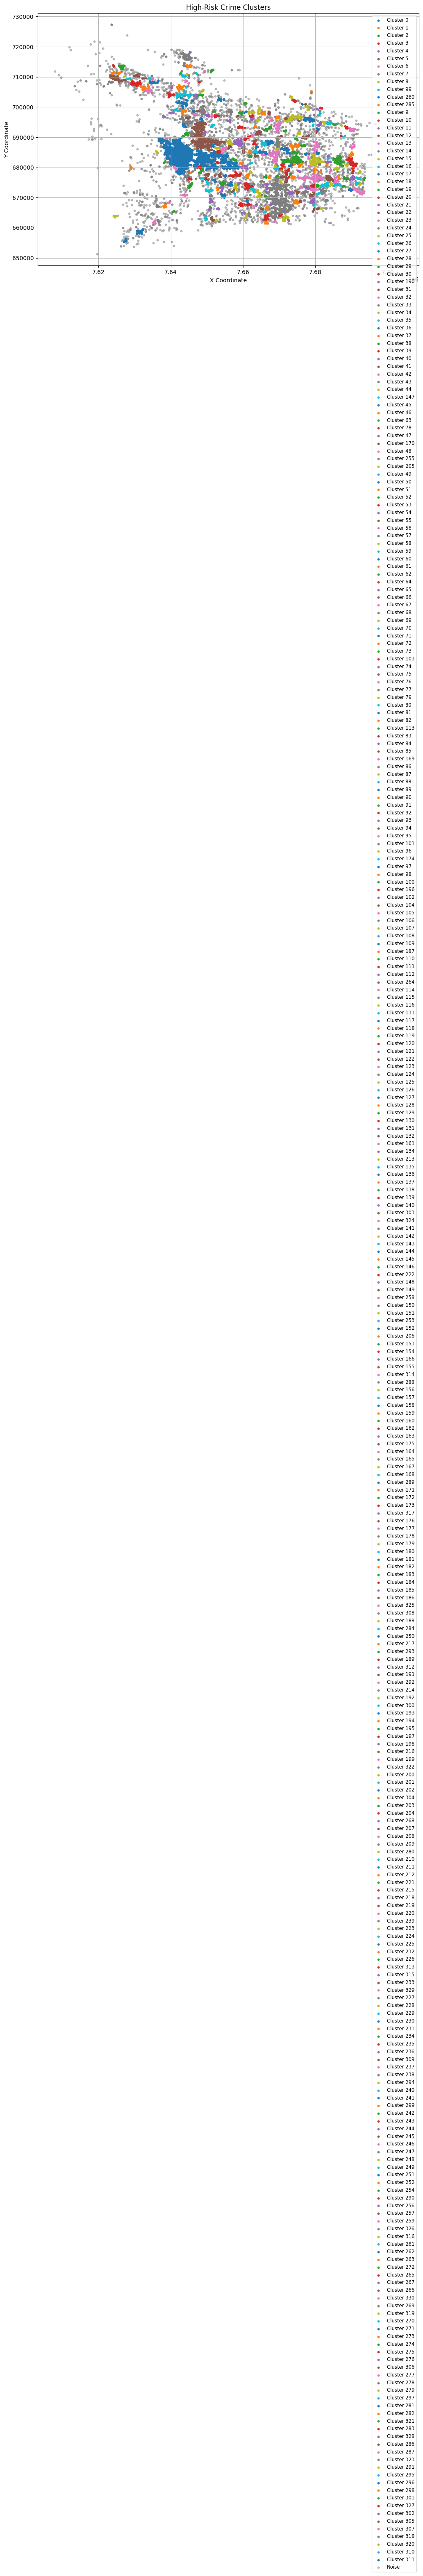

In [60]:

import pandas as pd
import folium
from sklearn.cluster import DBSCAN

# Load datasets
file_1 = '/content/NIJ2017_FEB01_FEB14.xlsx'
file_2 = '/content/NIJ2017_FEB15_FEB21.xlsx'
data_1 = pd.read_excel(file_1)
data_2 = pd.read_excel(file_2)

# Combine datasets
data = pd.concat([data_1, data_2], ignore_index=True)

# Rename columns for consistency
data.rename(columns=lambda x: x.strip().lower().replace(" ", "_"), inplace=True)

# Extract coordinates and drop missing values
coordinates = data[['x_coordinate', 'y_coordinate']].dropna()

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=500, min_samples=5).fit(coordinates)
data['hotspot_cluster'] = -1  # Default for rows without coordinates
data.loc[coordinates.index, 'hotspot_cluster'] = dbscan.labels_

# Filter for high-risk clusters
high_risk_data = data[data['hotspot_cluster'] != -1]

# Plot high-risk clusters
plt.figure(figsize=(12, 8))
for cluster_label in high_risk_data['hotspot_cluster'].unique():
    cluster_points = high_risk_data[high_risk_data['hotspot_cluster'] == cluster_label]
    plt.scatter(
        cluster_points['x_coordinate'],
        cluster_points['y_coordinate'],
        label=f'Cluster {cluster_label}',
        s=10
    )

# Highlight noise points (optional, if needed)
noise_points = data[data['hotspot_cluster'] == -1]
if not noise_points.empty:
    plt.scatter(
        noise_points['x_coordinate'],
        noise_points['y_coordinate'],
        color='gray',
        label='Noise',
        s=10,
        alpha=0.5
    )

# Plot customization
plt.title("High-Risk Crime Clusters")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.show()




#Merging both the datasets and evaluating the model for precision, recall, f1-score,

In [54]:
#Step 6
# Ensure only existing columns are dropped

# Define features and target
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Load the datasets
file1_path = '/content/NIJ2017_FEB01_FEB14.xlsx'
file2_path = '/content/NIJ2017_FEB15_FEB21.xlsx'
data1 = pd.read_excel(file1_path)
data2 = pd.read_excel(file2_path)

# Combine the datasets
data = pd.concat([data1, data2], ignore_index=True)

# Inspect column names to identify target and features
print("Columns in the dataset:", data.columns)

# Define the target column (replace with actual column name)
target_column = 'CATEGORY'  # Example: Replace with the actual target column name
X = data.drop(columns=[target_column], errors='ignore')  # Features
y = data[target_column]  # Target

# Drop datetime columns if present
datetime_columns = X.select_dtypes(include=['datetime64']).columns
X_clean = X.drop(columns=datetime_columns, errors='ignore')

# Convert non-numeric columns to numeric using label encoding
X_numeric = X_clean.copy()
for column in X_numeric.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_numeric[column] = le.fit_transform(X_numeric[column])

# Verify all columns are numeric
print(X_numeric.dtypes)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.3, random_state=42)

# Train a Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Evaluate the model
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))





Columns in the dataset: Index(['CATEGORY', 'CALL GROUPS', 'final_case_type', 'CASE DESC', 'occ_date',
       'x_coordinate', 'y_coordinate', 'census_tract'],
      dtype='object')
CALL GROUPS          int64
final_case_type      int64
CASE DESC            int64
x_coordinate         int64
y_coordinate         int64
census_tract       float64
dtype: object
                     precision    recall  f1-score   support

           BURGLARY       1.00      1.00      1.00        24
MOTOR VEHICLE THEFT       1.00      1.00      1.00        55
              OTHER       1.00      1.00      1.00      2853
      STREET CRIMES       1.00      1.00      1.00       504

           accuracy                           1.00      3436
          macro avg       1.00      1.00      1.00      3436
       weighted avg       1.00      1.00      1.00      3436



# Saving the Crime hotspot co-ordinates as Map data in crime_hotspots.html file

In [55]:
#step 7
# Visualize hotspots on a map using Folium
# Import required libraries
import folium
from folium.plugins import HeatMap
import pandas as pd
import pyproj

# Loading dataset
file1_path = '/content/NIJ2017_FEB01_FEB14.xlsx'
file2_path = '/content/NIJ2017_FEB15_FEB21.xlsx'
data1 = pd.read_excel(file1_path)
data2 = pd.read_excel(file2_path)

# Combine the datasets
data = pd.concat([data1, data2], ignore_index=True)

# Transform x_coordinate and y_coordinate to latitude and longitude
# Assuming EPSG:2272 to WGS84 for the transformation
transformer = pyproj.Transformer.from_crs("EPSG:2272", "EPSG:4326", always_xy=True)

data[['longitude', 'latitude']] = data.apply(
    lambda row: pd.Series(transformer.transform(row['x_coordinate'], row['y_coordinate'])),
    axis=1
)

# Drop rows with missing or invalid coordinates
data = data.dropna(subset=['latitude', 'longitude'])

# Create the map
crime_map = folium.Map(location=[data['latitude'].mean(), data['longitude'].mean()], zoom_start=12)

# Prepare heatmap data
heat_data = [[row['latitude'], row['longitude']] for _, row in data.iterrows()]
HeatMap(heat_data).add_to(crime_map)

# Save the map
output_file = "crime_hotspots.html"
crime_map.save(output_file)

print(f"Map saved as {output_file}")
output_file





Map saved as crime_hotspots.html


'crime_hotspots.html'

#PAI and PEI to predicts hotspots and evaluate the efficiency

In [56]:
#Step 8
# Define function for PAI and PEI
from sklearn.cluster import DBSCAN
import numpy as np

# Perform clustering to create 'hotspot_cluster'
coords = data[['latitude', 'longitude']].dropna().values  # Ensure no NaN values
db = DBSCAN(eps=0.01, min_samples=5).fit(coords)  # Adjust eps for your dataset

# Add 'hotspot_cluster' to the DataFrame
data['hotspot_cluster'] = -1  # Default to noise
data.loc[data[['latitude', 'longitude']].dropna().index, 'hotspot_cluster'] = db.labels_

# Define function for PAI and PEI
def calculate_pai_pei(predicted_hotspots, actual_crime_locations, area_of_city, area_of_hotspots):
    crime_in_hotspots = sum([1 for loc in actual_crime_locations if tuple(loc) in map(tuple, predicted_hotspots)])
    total_crimes = len(actual_crime_locations)

    pai = (crime_in_hotspots / area_of_hotspots) / (total_crimes / area_of_city)
    pei = crime_in_hotspots / len(predicted_hotspots)

    return pai, pei

# Calculate for the dataset
predicted_hotspots = data[data['hotspot_cluster'] != -1][['latitude', 'longitude']].values
actual_crime_locations = data[['latitude', 'longitude']].dropna().values
city_area = 100  # Replace with actual city area in km²
hotspot_area = len(predicted_hotspots) * 0.1  # Approximation

pai, pei = calculate_pai_pei(predicted_hotspots, actual_crime_locations, city_area, hotspot_area)
print(f"PAI: {pai}, PEI: {pei}")



PAI: 0.08731336767659129, PEI: 1.0
